In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import cloveFunctions as clv
import matplotlib
# matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
# matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import warnings
warnings.filterwarnings('ignore')
sns.set_style('white', {'xtick.bottom': False, 'ytick.left':False,'font.family': ['Arial']})

In [19]:
import pandas as pd
df = pd.DataFrame({ 'gene':["1 // foo // blabla",
                                   "2 // bar // lalala",
                                   "3 // qux // trilil",
                                   "4 // woz // hohoho",
                                   "nopeynope"], 
                   'cnv':['a','b','c','d','e'],
                   'cell1':[5,9,1,7,9], 
                   'cell2':[12,90,13,87,9],
                   'location':['1', '13.4', '1.1-2', '1.2-p22', '43-q44'],
                  'np_t_w': ['1','13.4','1.1','2','3']})
df['exp'] = ['e','f','g','h','i']
df

,cell1,cell2,cnv,gene,location,np_t_w,exp
0,5,12,a,1 // foo // blabla,1,1,e
1,9,90,b,2 // bar // lalala,13.4,13.4,f
2,1,13,c,3 // qux // trilil,1.1-2,1.1,g
3,7,87,d,4 // woz // hohoho,1.2-p22,2,h
4,9,9,e,nopeynope,43-q44,3,i


In [20]:
cnv = pd.DataFrame([[1,2,3],[4,5,6],[7,8,9]], index=['a', 'b','x'])
exp = pd.DataFrame([[1,2,3],[4,5,6],[7,8,9]], index=['e', 'h','x'])

In [17]:
df[(df['cnv'].isin(cnv.index)) & (df['exp'].isin(exp.index))]

,cell1,cell2,cnv,gene,location,np_t_w,exp
0,5,12,a,1 // foo // blabla,1,1,e


In [23]:
results = []
for pddf in [df, cnv, exp]:
    results.append(pddf)

for p in results:
    print(p)


   cell1  cell2 cnv                gene location np_t_w exp
0      5     12   a  1 // foo // blabla        1      1   e
1      9     90   b  2 // bar // lalala     13.4   13.4   f
2      1     13   c  3 // qux // trilil    1.1-2    1.1   g
3      7     87   d  4 // woz // hohoho  1.2-p22      2   h
4      9      9   e           nopeynope   43-q44      3   i
   0  1  2
a  1  2  3
b  4  5  6
x  7  8  9
   0  1  2
e  1  2  3
h  4  5  6
x  7  8  9


In [10]:
df['location'].str.extract('(-)', expand=True)

,0
0,NaN
1,NaN
2,-
3,-
4,-


In [16]:
df = pd.DataFrame([['a','b',1,'1p1'],
                  ['a','c',1.9,'1p1'],
                  ['a','d',45,'1p1'],
                  ['a','e',3.9,'1p1'],
                  ['b','c', 2.1,'1p2'],
                  ['b','d',-2,'1p2'],
                  ['b','e',4.1,'1p2'],
                  ['c','b',2,'1p3'],
                  ['c','c',2,'1p3'],
                  ['c','d',2,'1p3'],
                  ['c','e',2,'1p3'],
                  ['d','b',2,'1p4'],
                  ['d','c',2,'1p4'],
                  ['d','d',2,'1p4'],
                  ['d','e',2,'1p4']],
                 columns = ['cnv','exp','np_t_w', 'chromosome'])
df

,cnv,exp,np_t_w,chromosome
0,a,b,1.0,1p1
1,a,c,1.9,1p1
2,a,d,45.0,1p1
3,a,e,3.9,1p1
4,b,c,2.1,1p2
5,b,d,-2.0,1p2
6,b,e,4.1,1p2
7,c,b,2.0,1p3
8,c,c,2.0,1p3
9,c,d,2.0,1p3


In [32]:
rolling_similarity(df, how='cosine', group='cnv',data='np_t_w')

  chromosome cnv_g0 exp  clove_g0 cnv_g1  clove_g1
0        1p1      a   c       1.9      b       2.1
1        1p1      a   d      45.0      b      -2.0
2        1p1      a   e       3.9      b       4.1
  chromosome cnv_g0 exp  clove_g0 cnv_g1  clove_g1
0        1p1      a   b       1.0      c       2.0
1        1p1      a   c       1.9      c       2.0
2        1p1      a   d      45.0      c       2.0
3        1p1      a   e       3.9      c       2.0
  chromosome cnv_g0 exp  clove_g0 cnv_g1  clove_g1
0        1p1      a   b       1.0      d       2.0
1        1p1      a   c       1.9      d       2.0
2        1p1      a   d      45.0      d       2.0
3        1p1      a   e       3.9      d       2.0
  chromosome cnv_g0 exp  clove_g0 cnv_g1  clove_g1
0        1p2      b   c       2.1      c       2.0
1        1p2      b   d      -2.0      c       2.0
2        1p2      b   e       4.1      c       2.0
  chromosome cnv_g0 exp  clove_g0 cnv_g1  clove_g1
0        1p2      b   c       2

,cnv,exp,cosine
0,a,b,-0.308410
1,a,c,0.572759
2,a,d,0.572759
3,b,c,0.482854
4,b,d,0.482854
5,c,d,1.000000


In [31]:
from scipy.stats import pearsonr
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

def rolling_similarity(df, group='cnv', partners='exp', data='np_t_w', how='pearson', locus='chromosome'):
    """
    computes similarity between array of data for one gene partners and each successive chromosomal neighbor
    
    :param df: pd df, clove results, sorted in ascending order of chromosome locus
    :param group: str, df column label on which to form gene neigbors, default 'cnv'
    :param members: str, df column label on which to pair partners with gene neighbors, default 'exp'
    :param data: str, df column label of source data to populate arrays, default 'np_t_w' (clove t-stats)
    :param how: str, choice of: {pearson, euclidian, cosine}
    :param align: bool, False compares two arrays which don't necessarily have same gene index
    
    returns pd df of pairs, scores, and chosen similary metric, ordered by locus
    """
    
    unique_genes = df[group].unique()
    df = df[[locus, group, partners, data]].sort_values(by=locus)
    results = []
    for idx, g0 in enumerate(unique_genes):
        if idx < len(unique_genes) - 1:
            for idxk, gk in enumerate(unique_genes[idx+1:]):
                g1 = gk  # unique_genes[idx+1]
                merged = pd.merge(df[df[group] == g0], df[df[group] == g1][[partners,group,data]], how='inner', on=partners)
                merged.columns = [locus,'cnv_g0','exp','clove_g0','cnv_g1','clove_g1']
                print(merged)

                if how == 'pearson':
                    # produces NaN
                    cols = [group, partners, how ,'pval']
                    pear, pval = pearsonr(merged['clove_g0'], merged['clove_g1'])
                    results.append([g0,g1,pear,pval])
                elif how == 'euclidian':
                    cols = [group, partners, how]
                    d = distance.euclidean(merged['clove_g0'], merged['clove_g1'])
                    # error: (offx>=0 && offx<len(x)) failed for 2nd keyword offx: dnrm2:offx=0
                    results.append([g0, g1, d])
                elif how == 'cosine':
                    cols = [group, partners, how]
                    # error: (offx>=0 && offx<len(x)) failed for 2nd keyword offx: dnrm2:offx=0
                    d = cosine_similarity(merged['clove_g0'], merged['clove_g1'])[0][0]  
                    results.append([g0, g1, d])

#     return map_locus(pd.DataFrame(results, columns=cols))
    return pd.DataFrame(results, columns=cols)

In [27]:
df

,cell1,cell2,cnv,gene,location,np_t_w
0,5,12,a,1 // foo // blabla,1,1
1,9,90,b,2 // bar // lalala,13.4,13.4
2,1,13,c,3 // qux // trilil,1.1-2,1.1
3,7,87,d,4 // woz // hohoho,1.2-p22,2
4,9,9,e,nopeynope,43-q44,3


In [13]:
pearsonr?

develop explicit way to define certain combinations of genes on which to compute CLOvEs

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from cloveFunctions import *
import itertools

In [2]:
edf = pd.read_csv('data/breast_mrna.tab.gz', compression='gzip', sep='\t', index_col=0)
cdf = pd.read_csv('data/breast_CCLE_DEL_calls.csv.gz', compression='gzip', index_col=0)

In [3]:
e_samp = edf.index[1:3].values
c_samp = cdf.index[3:5].values

In [4]:
c_samp

array(['A2LD1', 'A2M'], dtype=object)

In [5]:
edf_f, cdf_f = mainFitler(edf, cdf, var=2, n=6, amp_fh=False, dele_fh=False, mut_fh=False, save=False)
df = explicitPairContextStat(edf_f, cdf_f, cnv_lis=c_samp)

attempting 3376 comparisons with current parameters


In [7]:
map_locus(df)

,cnv,exp,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,gene_var_exp,chromosome
0,A2M,AP1S2,6,53,7.319589,7.507049,1.387391,2.894021,-0.111297,-0.258386,0.797039,2.791326,12p13.31
22,A2M,MIEN1,6,53,11.207608,11.165550,2.228997,2.436755,0.026598,0.0617499,0.950978,2.457440,12p13.31
23,A2M,MLPH,6,53,10.511819,10.505350,5.335603,4.699409,0.002913,0.00676354,0.994627,4.846250,12p13.31
24,A2M,MREG,6,53,7.900807,7.478374,0.970711,2.610663,0.265600,0.616617,0.539942,2.502608,12p13.31
25,A2M,NAT1,6,53,8.542979,8.340457,3.623388,2.661422,0.119836,0.278212,0.781857,2.810634,12p13.31
26,A2M,OPN3,6,53,7.683450,8.180795,1.802795,2.257083,-0.328765,-0.763261,0.448455,2.271989,12p13.31
27,A2M,PDCD4,6,53,8.866148,8.602590,3.990745,2.304567,0.164630,0.382205,0.703731,2.525188,12p13.31
28,A2M,PLEKHF2,6,53,9.611975,9.099866,0.481288,2.389591,0.339707,0.788664,0.433576,2.257751,12p13.31
29,A2M,PLK2,6,53,11.220978,10.387761,0.711472,2.207939,0.571194,1.32608,0.190101,2.155715,12p13.31
30,A2M,RAB11FIP1,6,53,8.788833,8.510063,0.573247,2.737802,0.172686,0.400909,0.689986,2.568308,12p13.31


In [39]:
df['exp'].value_counts()

SH3YL1          2
RHPN2           2
HIST1H2BD       2
OPN3            2
HIST2H2BE       2
PLEKHF2         2
LOC100128822    2
MLPH            2
PLK2            2
SNHG5           2
NAT1            2
IL6ST           2
TSPAN13         2
CXXC5           2
RND3            2
DYNLT3          2
TRPS1           2
DNAJB4          2
RAB11FIP1       2
COTL1           2
FAM69A          2
MREG            2
IKBIP           2
AP1S2           2
SFN             2
KDELR3          2
RHOBTB3         2
MIEN1           2
CD9             2
FRMD6           2
HES1            2
TFAP2A          2
CEBPD           2
CREB3L4         2
SLC7A11         2
FAM46A          2
ID1             2
EXT1            2
MAFF            2
PDCD4           2
ELL3            2
Name: exp, dtype: int64

In [ ]:
cbar = fig.colorbar

### Subset large intestine data to get to 5 viz bait contexts

large intestine (source of viz dataset) doesn't have enough n-samples with context (probably why these were induced knockouts)"

In [8]:
csv = pd.read_csv('data/large_intestine_CCLE_DEL_calls.csv.gz', compression='gzip', index_col=0)
viz_bait = ['PTTG1', 'BLM','MUS81', 'PTEN', 'KRAS']
csv.loc[viz_bait].sum(axis=1)
# csv[csv['Name'].isin(viz_bait)]

Name
PTTG1    0
BLM      0
MUS81    2
PTEN     1
KRAS     0
dtype: int64

use all ccle cell lines

In [9]:
csv = pd.read_pickle('data/CCLE_DEL_calls.pickle')
viz_bait = ['PTTG1', 'BLM','MUS81', 'PTEN', 'KRAS']
csv = csv.loc[viz_bait].sum(axis=1)
csv.to_pickle('data/CCLE_DEL_calls_viz.pickle')

Name
PTTG1     18
BLM       19
MUS81      9
PTEN     102
KRAS      31
dtype: int64

In [4]:
explicitPairContextStat?

In [10]:
viz = pd.read_csv('data/viz_HCT116_GARP-score.txt.tar.gz',sep='\t', compression='gzip', index_col=0)

In [11]:
del viz['Gene ID']
del viz['Description']
del viz['Unnamed: 10']
viz.set_index('Gene Name', drop=True, inplace=True)
viz

,HCT116_BLM,HCT116_MUS81,HCT116_PTEN,HCT116_PWT,HCT116_PTTG1,HCT116_WT
Gene Name,,,,,,
WDR11,-0.156363,-0.306122,-0.357102,-0.084159,-0.413263,-0.121228
OR10A2,-0.055357,-0.109505,-0.077226,-0.070077,-0.127857,-0.059772
MRPS12,-0.111989,-0.059505,-0.184910,-0.066028,-0.217499,-0.039225
MPV17L,-0.036167,-0.148610,-0.225790,-0.068753,-0.239617,-0.051944
TFPI2,-0.180304,-0.315834,-0.387426,-0.190001,-0.292052,-0.091514
NUDT15,-0.019991,-0.096132,-0.135179,-0.073432,-0.187830,-0.051562
TRMT1,-0.319461,-0.101908,-0.093429,-0.118008,-0.220807,-0.064457
PNOC,0.019299,-0.086702,-0.001842,-0.071489,-0.029707,-0.009812
EVI2B,-0.018433,-0.155776,-0.078900,-0.057902,-0.229445,-0.065921


## Compute Some Sample Breast CLOvE - copynumber only

In [172]:
# from cloveFunctions import *

# def compute_breast_cloves(save=False):
#     cdel = pd.read_pickle('data_large/CCLE_DEL_calls.pickle')
# #     cellinfo = pd.read_pickle('data_large/ccle_cell_info_df.pickle')
#     exp_breast = pd.read_pickle('data/breast_mrna_df.pickle')

#     # this filtering step requires subsetting cdel to tissue of interest (breast)
#     cells = list(set(cdel.columns).intersection(exp_breast.columns)) 
#     cdel_breast = cdel[cells]
#     cdel_breast.to_csv('data/breast_cnv_df.pickle')
    
#     df=randomPairContextStat(100000, exp_breast, cdel_breast, nan_style='propagate')
    
#     if save:
#         df.to_csv('data/breast_ttest_real_samp.tab.gz', sep='\t', compression='gzip')
#     return df

# def load_breast_cloves():
#     return  pd.read_csv('data/breast_ttest_real_samp.tab.gz', sep='\t', compression='gzip', index_col=0)

## Compute Some Kidney CLOvE

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import cloveFunctions as clv
import matplotlib
# matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
# matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import warnings
warnings.filterwarnings('ignore')

In [4]:
celldf[celldf['Site Primary'].str.contains('kidney')].index

lung                                  187
haematopoietic_and_lymphoid_tissue    181
central_nervous_system                 69
large_intestine                        62
skin                                   62
breast                                 60
ovary                                  52
pancreas                               46
stomach                                38
kidney                                 36
upper_aerodigestive_tract              33
bone                                   29
liver                                  28
endometrium                            28
urinary_tract                          28
oesophagus                             27
soft_tissue                            21
autonomic_ganglia                      17
thyroid                                12
pleura                                 11
prostate                                8
biliary_tract                           8
salivary_gland                          2
small_intestine                   

In [34]:
cnv = pd.read_pickle('data_large/CCLE_DEL_calls.pickle')
exp = pd.read_pickle('data/kidney_mrna_df.pickle')
exp.to_csv('data/kidney_DEL_calls_tab.gz', sep='\t', compression='gzip')
kidney_cells2 = list(set(exp.columns).intersection(cnv.columns))
cnv[kidney_cells2].to_csv('data/kidney_DEL_calls_df.gz', sep='\t', compression='gzip')


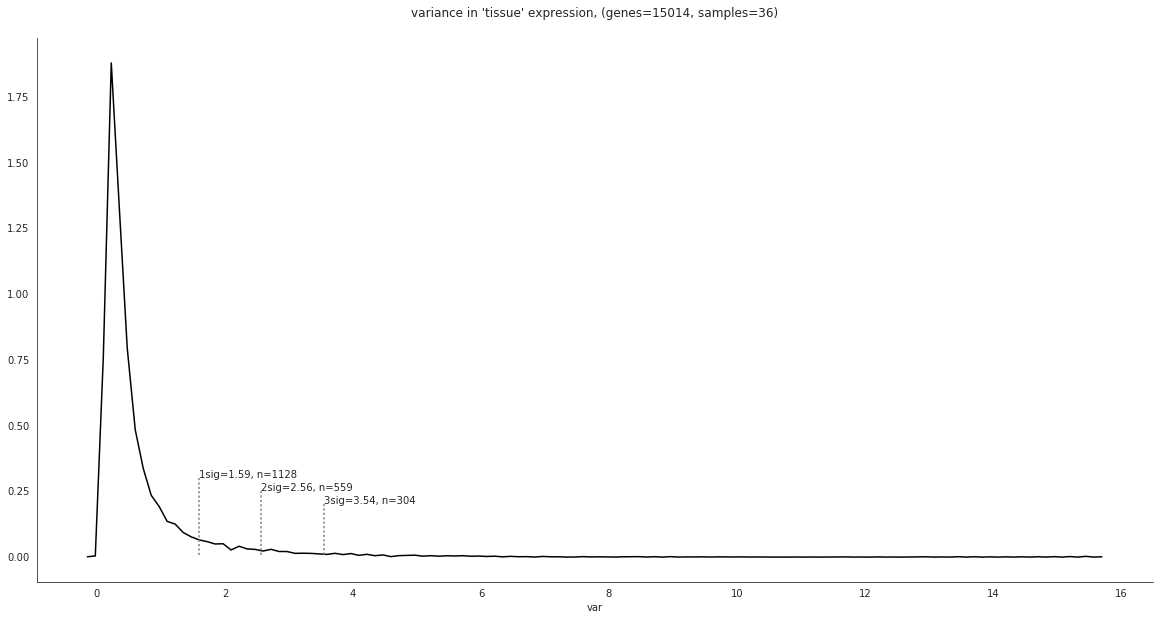

mean:  2.1613484302624806
std:  3.7810021582275386


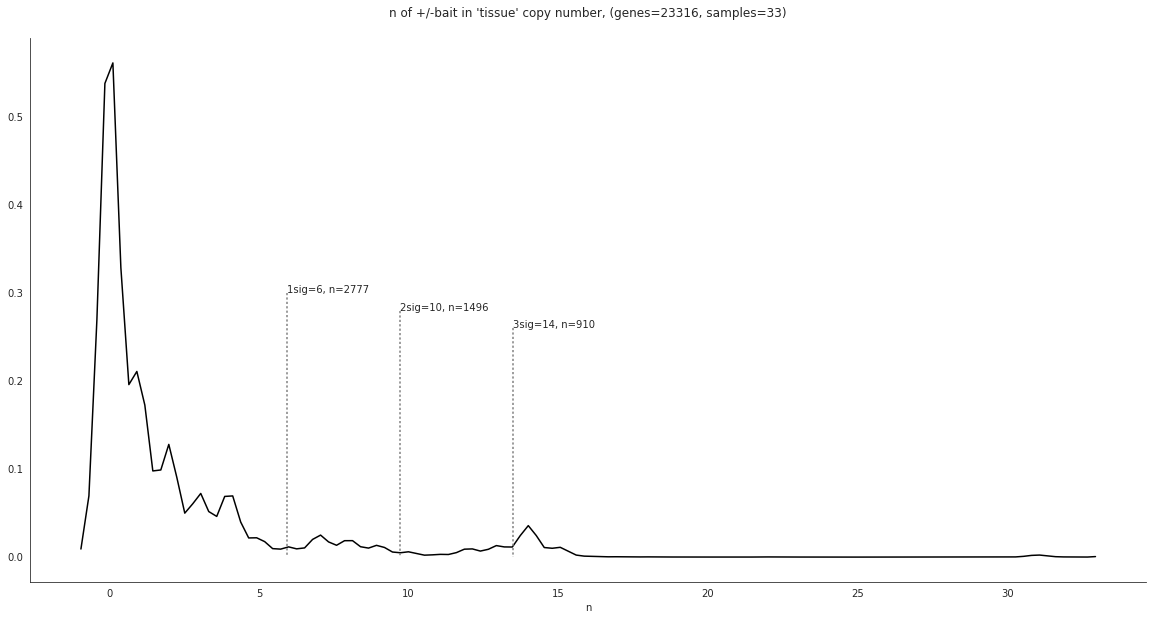

In [39]:
expdf, cnvdf = clv.load_data('data/kidney_DEL_calls_tab.gz', 'data/kidney_DEL_calls_df.gz')

In [41]:
expdf, cnvdf = clv.mainFitler(expdf, cnvdf, var=1, n=6)

exp: (15014, 36) --> filter --> (1988, 33)
cnv: (23316, 33) --> filter --> (2729, 33)
5425252 CLOvE pairs are possible with these parameters
estimated calculation time: 63.294606666666674min (~7sec/10k pairs)


In [43]:
kid_cloves_ccle = clv.randomPairContextStat(1000000, expdf, cnvdf, verbose=False, cat_df=False, nan_style='omit', permute=True)

attempting 1000000 of 5425252 total possible pairs post-filtering
pair computation 10% complete (100000/5425252)
pair computation 20% complete (200000/5425252)
pair computation 30% complete (300000/5425252)
pair computation 40% complete (400000/5425252)
pair computation 50% complete (500000/5425252)
pair computation 60% complete (600000/5425252)
pair computation 70% complete (700000/5425252)
pair computation 80% complete (800000/5425252)
pair computation 90% complete (900000/5425252)
pair computation 100% complete (1000000/5425252)


In [44]:
kid_cloves_ccle.to_csv('data/kidney_ttest_1M.tab.gz', compression='gzip', sep='\t')

## FIX explicitpair to make all comparisons possible, add to list of list --> df and get timer

In [4]:
from cloveFunctions import *

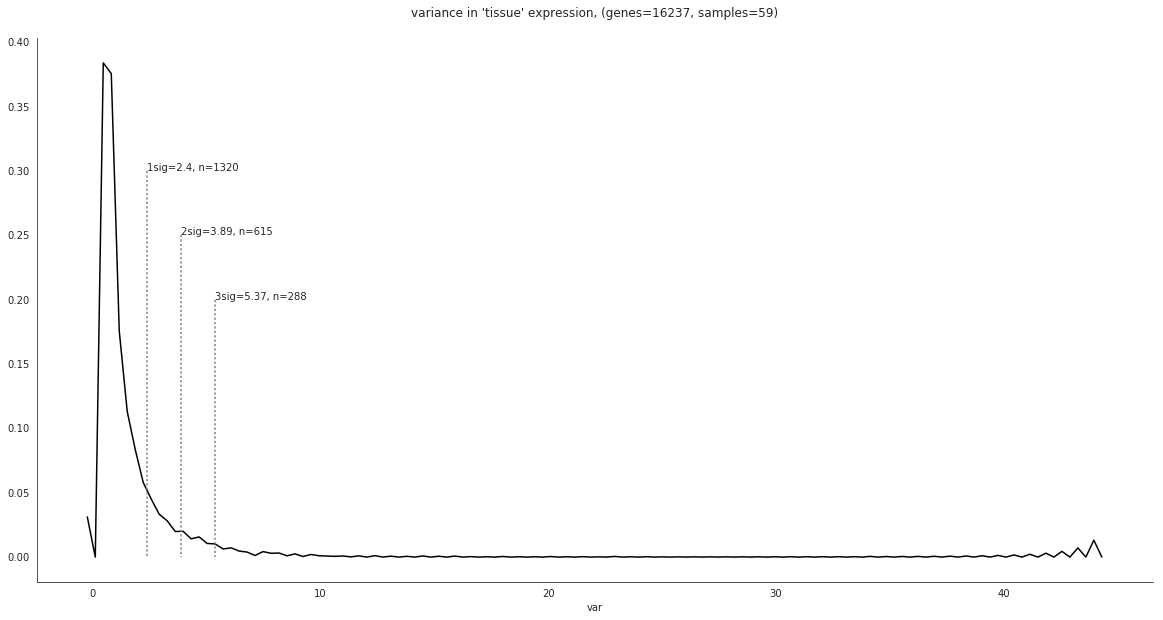

mean:  3.109752959341225
std:  4.487808451182486


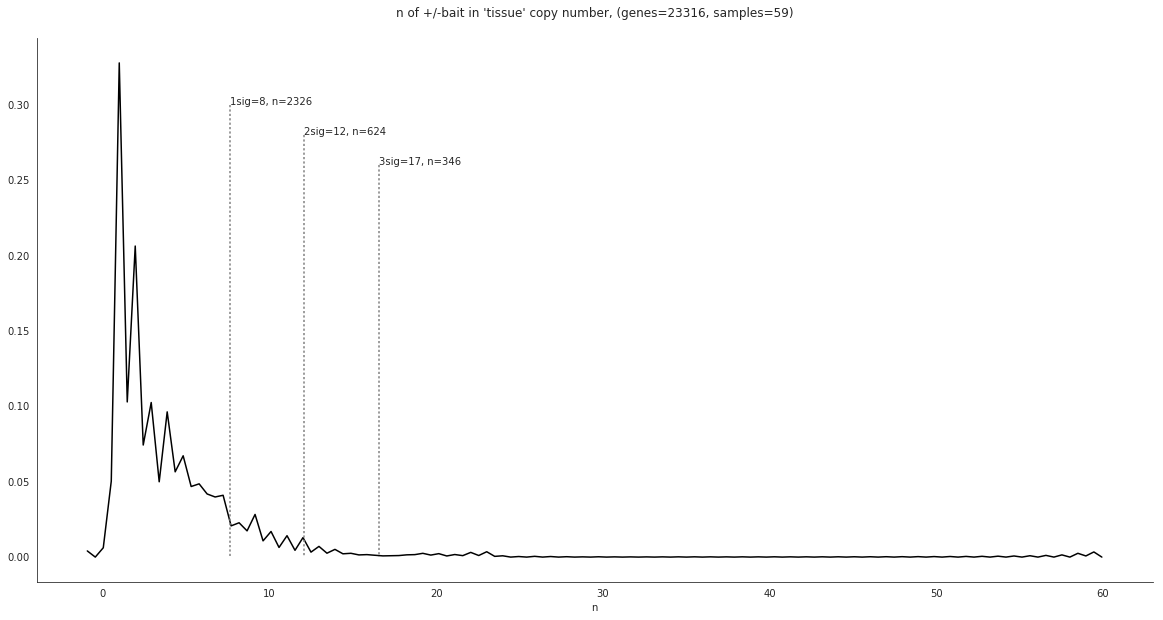

In [5]:
expdf, cnvdf = load_data('data/breast_mrna.tab.gz', 'data/breast_CCLE_DEL_calls.csv.gz')

In [6]:
expdf, cnvdf = mainFitler(expdf, cnvdf, var=2, n=8)

exp: (16237, 59) --> filter --> (1688, 59)
cnv: (23316, 59) --> filter --> (2278, 59)
3845264 CLOvE pairs are possible with these parameters
estimated calculation time: 44.86141333333333min (~7sec/10k pairs)


In [16]:
comparisons = len(expdf.index) * len(cnvdf.index)
round(comparisons,-1)

3845260

In [78]:
# explicitPairContextStat edited here and moved to cloveFunctions

In [44]:
%%time
breast_results = explicitPairContextStat(expdf, cnvdf)

# attempting 3845264 comparisons with current parameters
# CPU times: user 2h 24min 4s, sys: 55.2 s, total: 2h 24min 59s
# Wall time: 2h 24min 3s

attempting 3845264 comparisons with current parameters
 estimate duration 100.0min
pair computation 10% complete (384526/3845264)
pair computation 20% complete (769052/3845264)
pair computation 30% complete (1153578/3845264)
pair computation 40% complete (1538104/3845264)
pair computation 50% complete (1922630/3845264)
pair computation 60% complete (2307156/3845264)
pair computation 70% complete (2691682/3845264)
pair computation 80% complete (3076208/3845264)
pair computation 90% complete (3460734/3845264)
pair computation 100% complete (3845260/3845264)
CPU times: user 2h 24min 4s, sys: 55.2 s, total: 2h 24min 59s
Wall time: 2h 24min 3s


In [52]:
bdf = breast_results.dropna()

In [77]:
bdf.to_csv('data/breast_ttest_nonull_n2v8.tab.gz', compression='gzip', sep='\t')

## Compute Some Sample Breast CLOvE - copynumber with mutation

just copy number

In [43]:
clove_CN = pd.read_csv('data/breast_ttest_nonull_n2v8.tab.gz', compression='gzip', sep='\t', index_col=0)
null = pd.read_pickle('data/breast_ttest_null_samp.p').dropna(axis=0, how='any')

Ttest_indResult(statistic=-13.278996303321879, pvalue=3.0750771578143149e-40)


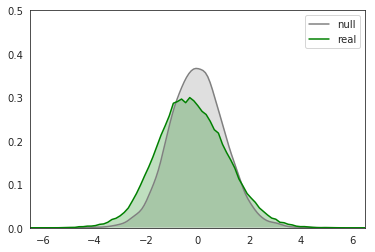

In [177]:
%matplotlib inline
sns.kdeplot(null['t_stat'], color='gray', shade=True, label='null')
sns.kdeplot(clove_CN['np_t_w'], color='green', shade=True, label='real')
plt.xlim(-6.5, 6.5)
plt.ylim(0.00, 0.50)
print(stats.ttest_ind(clove_CN['np_t_w'],null['t_stat']))

just mutation

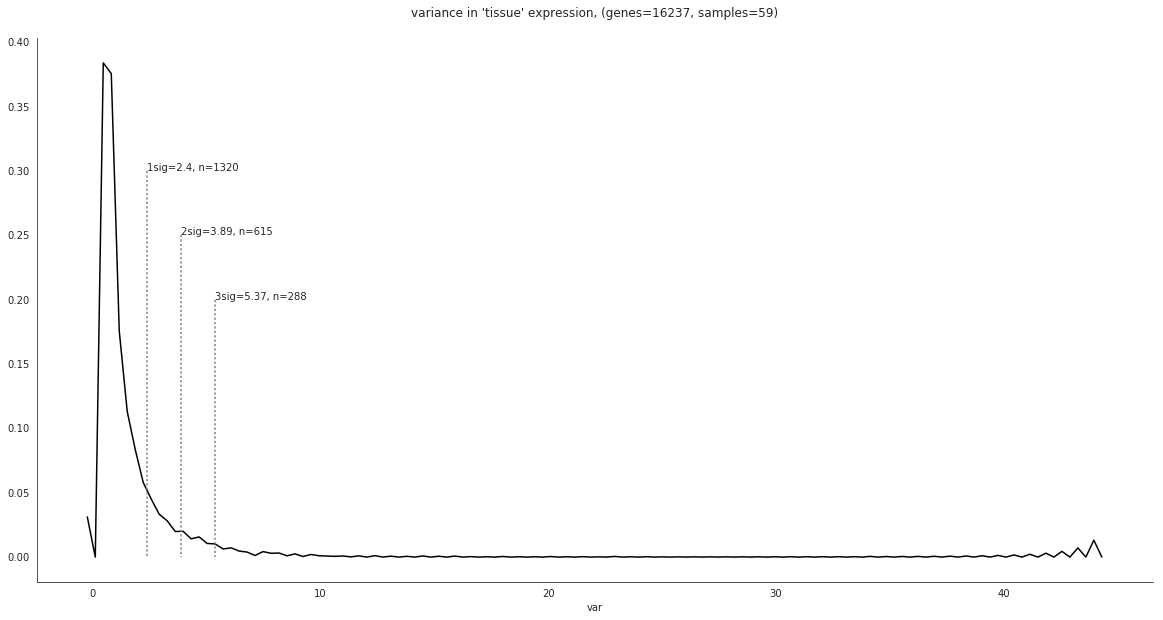

mean:  0.9395604395604396
std:  1.6624519021412687


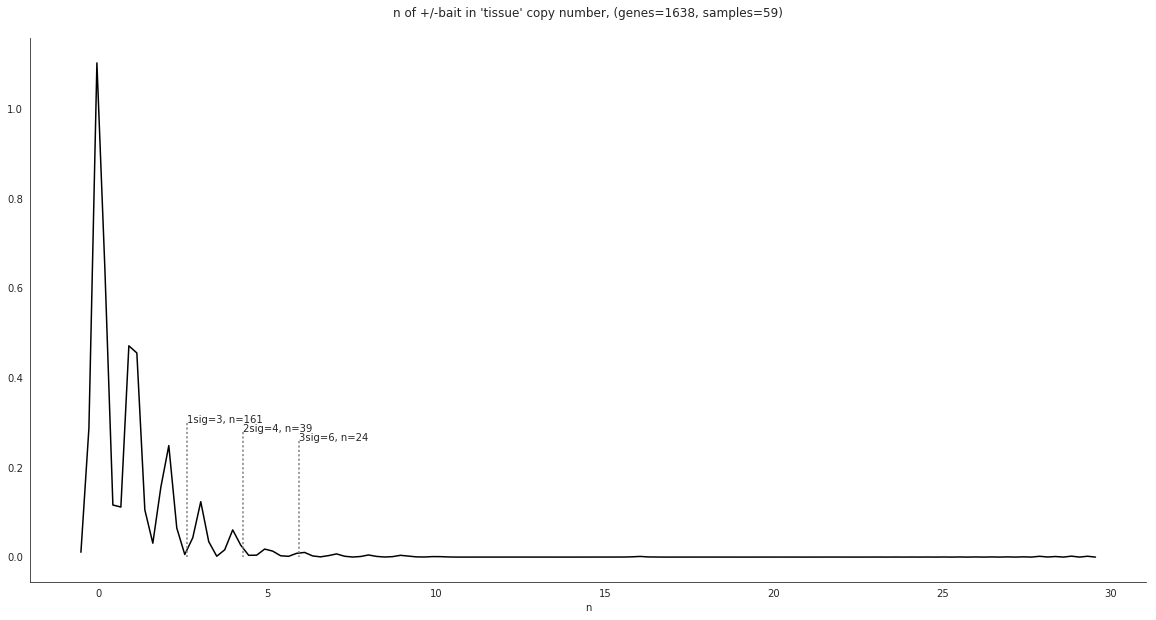

In [37]:
mutdf = pd.read_pickle('data_large/CCLE_MUT_calls.pickle')
breast = [col for col in mutdf.columns if 'BREAST' in col]
mutdf = mutdf[breast]
mutdf.to_csv('data/breast_CCLE_MUT_calls.csv.gz', compression='gzip', sep='\t')
expdf, mutdf = clv.load_data('data/breast_mrna.tab.gz', 'data/breast_CCLE_MUT_calls.csv.gz', details=True)

In [13]:
syndb = pd.read_pickle('data/synlethdb_sl_human.pickle')

In [32]:
common_mutdf = pd.DataFrame(syndb['GeneASymbol'].value_counts())
common_mut = common_mutdf.head(100)[['GeneASymbol']].index
common_mut

Index(['HRAS', 'KRAS', 'NAE1', 'NRAS', 'ABCB1', 'MYC', 'ABCG2', 'ABL1',
       'ABCA3', 'ALB', 'BCR/ABL fusion', 'CYP2C9', 'CYP3A7', 'CYP3A4',
       'CYP3A5', 'CSF1R', 'ABCC10', 'DDR1', 'CYP2D6', 'CYP1A2', 'CYP2C19',
       'EGFR', 'KIT', 'BRCA1', 'BCL2', 'CDA', 'CMPK1', 'DCK', 'NTRK1', 'ORM1',
       'PDGFRB', 'ATM', 'PDGFRA', 'PTGS1', 'PARP1', 'CDK6', 'CDK2', 'AKT1',
       'BID', 'RET', 'CDK4', 'CETN2', 'ABCC1', 'ABCB11', 'CAPRIN1', 'ABCC2',
       'DNTT', 'BRCA2', 'CASP3', 'HIST1H4A', 'GTF2H1', 'ERCC1', 'CARS',
       'HIST1H2AE', 'KDR', 'MDM2', 'API5', 'MTOR', 'IGF1', 'AURKA', 'SLC22A2',
       'IGFBP3', 'SLC22A1', 'CHEK1', 'RRM1', 'CYP2C8', 'ATR', 'CYP1B1',
       'IGHMBP2', 'CYP19A1', 'CALM1', 'HRSP12', 'RAD51', 'BAX', 'MT1X', 'CTSB',
       'PARP2', 'POLD1', 'MAPK12', 'CASP8', 'BCL2L1', 'NHP2', 'CPSF1', 'CSHL1',
       'ATAD5', 'ADAM22', 'ARPC5', 'ATP2C2', 'CLPX', 'ABCB6', 'CUX1',
       'CACNA2D2', 'BCL2L11', 'ATP7A', 'PMS2', 'POLE', 'DLAT', 'CDC7', 'CD46',
       'AKR7A2'],


In [36]:
# expdf, mutdf = clv.mainFitler(expdf, mutdf, var=.1, n=1)

exp: (16237, 59) --> filter --> (0, 0)
cnv: (1638, 59) --> filter --> (0, 0)
0 CLOvE pairs are possible with these parameters
estimated calculation time: 0.0min (~7sec/10k pairs)


In [58]:
m = mutdf.loc[common_mutdf.index].dropna()
m.sum(axis=1)

HRAS        2.0
KRAS        2.0
NRAS        0.0
MYC         0.0
ABL1        3.0
ABCA3       3.0
CYP3A4      1.0
CSF1R       2.0
DDR1        0.0
CYP1A2      2.0
EGFR        1.0
KIT         2.0
BRCA1       1.0
BCL2        0.0
NTRK1       3.0
PDGFRB      1.0
ATM         4.0
PDGFRA      1.0
PARP1       1.0
CDK6        0.0
CDK2        1.0
AKT1        0.0
BID         0.0
RET         0.0
CDK4        0.0
BRCA2       7.0
CASP3       1.0
CARS        1.0
KDR         1.0
MDM2        0.0
           ... 
CTBP2       1.0
FLNB        1.0
HIF1A       1.0
SLK         0.0
STK33       0.0
ISG15       0.0
LATS1       3.0
EWSR1       0.0
CSNK2A2     0.0
NAV3        4.0
MST1R       4.0
BTRC        2.0
DUSP6       1.0
SNRK        0.0
CD79A       0.0
GPHN        1.0
MSH5        2.0
CCNB1IP1    0.0
MAP3K5      0.0
TAOK3       0.0
ADAMTS2     0.0
RHOA        2.0
ORAOV1      0.0
IL2RA       0.0
STK10       0.0
SGK2        0.0
IL1A        0.0
IKZF1       0.0
CCNA1       4.0
BIRC6       8.0
dtype: float64

In [69]:
new_col = [col.split('_BREAST')[0] for col in mutdf.columns]
mutdf.columns = new_col
mutdf.sort_index(axis=1, inplace=True)
mutdf.to_csv('data/breast_CCLE_MUT_calls.csv.gz', compression='gzip', sep='\t')



In [76]:
mutdf

,AU565,BT20,BT474,BT483,BT549,CAL120,CAL148,CAL51,CAL851,CAMA1,...,MDAMB436,MDAMB453,MDAMB468,SKBR3,T47D,UACC812,UACC893,YMB1,ZR751,ZR7530
Name,,,,,,,,,,,,,,,,,,,,,
AAK1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AATK,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
ABCA3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
ABCC3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABCC4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABI1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABL1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ABL2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACACA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
%%time
breast_mut = clv.explicitPairContextStat(expdf, mutdf, cnv_lis=common_mut)

NAE1 not found in cnvdf.index.  Omitted
ABCB1 not found in cnvdf.index.  Omitted
ABCG2 not found in cnvdf.index.  Omitted
ALB not found in cnvdf.index.  Omitted
BCR/ABL fusion not found in cnvdf.index.  Omitted
CYP2C9 not found in cnvdf.index.  Omitted
CYP3A7 not found in cnvdf.index.  Omitted
CYP3A5 not found in cnvdf.index.  Omitted
ABCC10 not found in cnvdf.index.  Omitted
CYP2D6 not found in cnvdf.index.  Omitted
CYP2C19 not found in cnvdf.index.  Omitted
CDA not found in cnvdf.index.  Omitted
CMPK1 not found in cnvdf.index.  Omitted
DCK not found in cnvdf.index.  Omitted
ORM1 not found in cnvdf.index.  Omitted
PTGS1 not found in cnvdf.index.  Omitted
CETN2 not found in cnvdf.index.  Omitted
ABCC1 not found in cnvdf.index.  Omitted
ABCB11 not found in cnvdf.index.  Omitted
CAPRIN1 not found in cnvdf.index.  Omitted
ABCC2 not found in cnvdf.index.  Omitted
DNTT not found in cnvdf.index.  Omitted
HIST1H4A not found in cnvdf.index.  Omitted
GTF2H1 not found in cnvdf.index.  Omitted
ER

In [82]:
breast_mut.dropna(inplace=True)
breast_mut.sort_values(by='np_t_w', ascending=False, inplace=True)

In [ ]:
breast_mut.to_csv('data/breast_ttest_real_MUT_top100syndb.tab.gz', compression='gzip', sep='\t')

Ttest_indResult(statistic=nan, pvalue=nan)


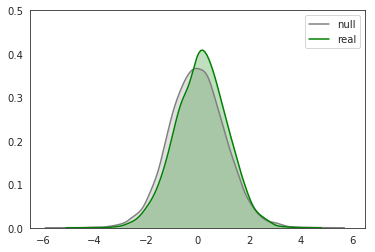

In [74]:
%matplotlib inline
sns.kdeplot(null['t_stat'], color='gray', shade=True, label='null')
sns.kdeplot(breast_mut['np_t_w'], color='green', shade=True, label='real')
plt.xlim(-6.5, 6.5)
plt.ylim(0.00, 0.50)
print(stats.ttest_ind(breast_mut['np_t_w'],null['t_stat']))

In [75]:
%%time
breast_mut_all = clv.explicitPairContextStat(expdf, mutdf, cnv_lis=common_mutdf.index)

NAE1 not found in cnvdf.index.  Omitted
ABCB1 not found in cnvdf.index.  Omitted
ABCG2 not found in cnvdf.index.  Omitted
ALB not found in cnvdf.index.  Omitted
BCR/ABL fusion not found in cnvdf.index.  Omitted
CYP2C9 not found in cnvdf.index.  Omitted
CYP3A7 not found in cnvdf.index.  Omitted
CYP3A5 not found in cnvdf.index.  Omitted
ABCC10 not found in cnvdf.index.  Omitted
CYP2D6 not found in cnvdf.index.  Omitted
CYP2C19 not found in cnvdf.index.  Omitted
CDA not found in cnvdf.index.  Omitted
CMPK1 not found in cnvdf.index.  Omitted
DCK not found in cnvdf.index.  Omitted
ORM1 not found in cnvdf.index.  Omitted
PTGS1 not found in cnvdf.index.  Omitted
CETN2 not found in cnvdf.index.  Omitted
ABCC1 not found in cnvdf.index.  Omitted
ABCB11 not found in cnvdf.index.  Omitted
CAPRIN1 not found in cnvdf.index.  Omitted
ABCC2 not found in cnvdf.index.  Omitted
DNTT not found in cnvdf.index.  Omitted
HIST1H4A not found in cnvdf.index.  Omitted
GTF2H1 not found in cnvdf.index.  Omitted
ER

KeyboardInterrupt: 

In [ ]:
breast_mut.to_csv('data/breast_ttest_real_MUT_allsyndb.tab.gz', compression='gzip', sep='\t')

mutaion with copy number

In [ ]:
mcdf = pd.read_csv('data_large/CCLE_MUT_DEL_calls_inner.tab.gz')
breast = [col for col in mcdf.columns if 'BREAST' in col]
mcdf = mcdf[breast]
new_col = [col.split('_BREAST')[0] for col in mcdf.columns]
mcdf.columns = new_col
mcdf.to_csv('data/breast_CCLE_MUT_DEL_calls_inner.tab.gz', compression='gzip', sep='\t')
expdf, mutdf = clv.load_data('data/breast_mrna.tab.gz', 'data/breast_CCLE_MUT_DEL_calls_inner.tab.g', details=True)

In [ ]:
# expdf, mutdf = clv.mainFitler(expdf, mutdf, var=2, n=3)

In [ ]:
%%time
breast_mut = clv.explicitPairContextStat(expdf, mutdf)

## fig 2: boxplot of t-stats of pairs in SynlethDB (+) vs not in SynLethdb (-)

In [72]:
syndb = pd.read_pickle('data/synlethdb_sl_human.pickle')
syndb['bait:prey'] = syndb['GeneASymbol']  + ":" + syndb['GeneBSymbol']
bdf = pd.read_csv('data/breast_ttest_nonull_n2v8.tab.gz', compression='gzip', sep='\t', index_col=0)
bdf['bait:prey'] = bdf['cnv'] + ':' + bdf['exp']

In [141]:
indb = bdf[bdf['bait:prey'].isin(syndb['bait:prey'])]
indb[''] = 'known lethal'




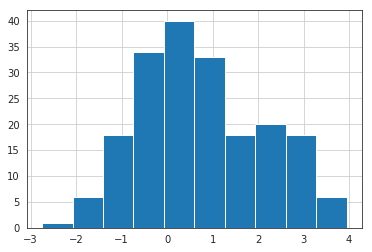

In [155]:
%matplotlib inline
# indb['np_t_w'] = indb['np_t_w'] * -1
# indb['np_t_w'] = indb['np_t_w'] + 0.1
indb['np_t_w'].hist()

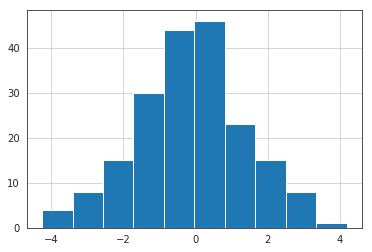

In [156]:
outdb = bdf[~bdf['bait:prey'].isin(syndb['bait:prey'])].sample(indb.shape[0])
outdb[''] = 'unknown lethal'
outdb['np_t_w'].hist()

In [157]:
in_vs_out = pd.concat([indb, outdb])
in_vs_out.rename(columns={'np_t_w':'t-statistic'}, inplace=True)

In [158]:
in_vs_out

,cnv,exp,t-statistic,np_p_w,bait:prey,
289461,BCL2,BIRC3,0.111188,0.774648,BCL2:BIRC3,known lethal
360079,BCL2,C1S,1.174267,0.447015,BCL2:C1S,known lethal
526373,BCL2,CD9,-0.524601,0.359071,BCL2:CD9,known lethal
565099,BCL2,CDKN1A,2.021426,0.110861,BCL2:CDKN1A,known lethal
1061587,ADORA2B,EMP1,1.654397,0.216034,ADORA2B:EMP1,known lethal
1098151,BCL2,ERBB2,-1.174658,0.120969,BCL2:ERBB2,known lethal
1132196,ADAM9,F2RL1,-1.009203,0.165090,ADAM9:F2RL1,known lethal
1132690,DSG2,F2RL1,-1.001673,0.167316,DSG2:F2RL1,known lethal
1225719,BCL2,FGF2,1.328522,0.363213,BCL2:FGF2,known lethal
1430749,BMP1,GNG12,3.206464,0.006914,BMP1:GNG12,known lethal


Ttest_indResult(statistic=5.840785816362815, pvalue=1.1042188445872051e-08)
Ks_2sampResult(statistic=0.23195876288659789, pvalue=4.4284197515723007e-05)


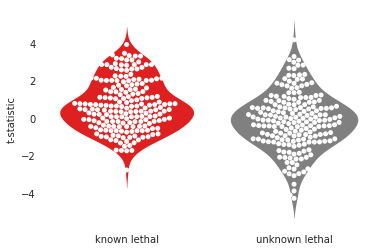

In [161]:
%matplotlib inline
# sns.boxplot(x='indb', y='np_t_w', data=in_vs_out, width=0.5)
# fig, ax = plt.subplots()
# # Edit labels.
# ax.set_ylabel('t-statistic')    
# ax.set_xlabel('')

sns.violinplot(x='', y='t-statistic', data=in_vs_out, palette=['red','gray'], linewidth=0)
sns.swarmplot(x='', y='t-statistic', data=in_vs_out, color='white')
sns.despine(left=True, bottom=True)

print(stats.ttest_ind(in_vs_out[in_vs_out['']=='known lethal']['t-statistic'],
                     in_vs_out[in_vs_out['']=='unknown lethal']['t-statistic']))
print(stats.ks_2samp(in_vs_out[in_vs_out['']=='known lethal']['t-statistic'],
                     in_vs_out[in_vs_out['']=='unknown lethal']['t-statistic']))

In [170]:
in_vs_out_d = in_vs_out.merge(how='outer', right=syndb, left_on='bait:prey', right_on='bait:prey')
in_vs_out_d.dropna(inplace=True)
in_vs_out_d['prod'] = in_vs_out_d['DiseaseScore'] * in_vs_out_d['t-statistic']
in_vs_out_d.sort_values('prod', ascending=False, inplace=True)
# in_vs_out_d[in_vs_out_d['Species'].str.contains('breast')]
in_vs_out_d[['cnv','exp','t-statistic', 'DiseaseScore']]

,cnv,exp,t-statistic,DiseaseScore
106,NADK,NRAS,3.941040,0.4550
121,EGR3,PDGFRA,3.383689,0.5180
53,COPS3,NRAS,3.187911,0.5180
86,HMGN2,NRAS,3.352300,0.4760
75,EXOSC10,NRAS,3.322497,0.4760
104,MMEL1,NRAS,3.472038,0.4520
103,MLL,NRAS,2.855575,0.5240
115,NMNAT1,NRAS,3.322497,0.4490
79,FBXW10,NRAS,3.118840,0.4640
100,MAPK7,NRAS,3.118840,0.4610


## fig 3: waterfall plot of breast data

In [29]:
syndb = pd.read_pickle('data/synlethdb_sl_human.picklelethdb_sl_human.pickle')

In [3]:
bdf = pd.read_csv('data/breast_ttest_nonull_n2v8.tab.gz', compression='gzip', sep='\t', index_col=0)

In [ ]:
bdf = bdf.sort_values(by='np_t_w')
bdf['bait:prey'] = bdf['cnv'] + bdf['exp']

bdf_samp = bdf.sample(100).sort_values(by='np_t_w')

([], <a list of 0 Text xticklabel objects>)

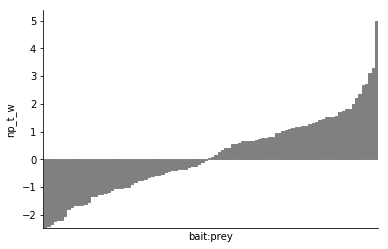

In [31]:
best_samp = bdf.sample(100).sort_values(by='np_t_w')
best_ratio = 1
best_diff = 0
updates = 0
for x in range(5000):
    samp = bdf.sample(100).sort_values(by='np_t_w')
    if samp[samp['np_t_w'] > 0].shape[0] > samp[samp['np_t_w'] < 0].shape[0]:
        if abs(samp['np_t_w'].min()) < abs(samp['np_t_w'].max()):
            ratio = abs(samp[samp['np_t_w'] > 0]['np_t_w'].product())/abs(samp[samp['np_t_w'] < 0]['np_t_w'].product())
            diff = abs(samp['np_t_w'].max()) - abs(samp['np_t_w'].min())
            if (ratio > best_ratio) & (diff > best_diff):
                best_ratio = ratio
                best_diff = diff
                best_samp = samp
                updates += 1
%matplotlib inline
sns.barplot(x='bait:prey', y='np_t_w', data=best_samp, color='gray', edgecolor='gray')
sns.despine()
plt.xticks([])
        

In [33]:
best_samp.to_csv('data/fig3_waterfall_brca1.tab.gz', compression='gzip', sep='\t')

In [47]:
bdf['bait:prey'] = bdf['cnv'] + ":" + bdf['exp'] 
syndb['bait:prey'] = syndb['GeneASymbol']  + ":" + syndb['GeneBSymbol']
m1 = pd.merge(left=bdf, right=syndb, left_on='bait:prey', right_on='bait:prey')  # 194 rows
syndb['bait:prey'] = syndb['GeneBSymbol'] + ":" + syndb['GeneASymbol']
m2 = pd.merge(left=bdf, right=syndb, left_on='bait:prey', right_on='bait:prey') # 161 rows

merged = pd.concat([m1, m2])

In [58]:
merged['product'] = merged['np_t_w'] * merged['DiseaseScore']
merged.sort_values(by='product', ascending=False, inplace=True)
top10 = merged.drop_duplicates(['cnv','exp']).head(10)['bait:prey']


In [53]:
merged[(merged['bait:prey'].str.contains('PARP')) | (merged['bait:prey'].str.contains('BRCA'))]

,cnv,exp,np_t_w,np_p_w,bait:prey,GeneASymbol,GeneAid,GeneBSymbol,GeneBid,PubmedID,Evidence,Type,Species,DiseaseScore
95,BRCA1,IGFBP3,-0.185545,0.853655,BRCA1:IGFBP3,BRCA1,672,IGFBP3,3486,3965078,Decipher,SL,"A549,PC3,MDA468",0.5450
115,BRCA1,ABCG2,0.363655,0.720131,BRCA1:ABCG2,ABCG2,9429,BRCA1,672,20145144,Text Mining,SL,breast cancer_D001943,0.1775


In [64]:
merged

,cnv,exp,np_t_w,np_p_w,bait:prey,GeneASymbol,GeneAid,GeneBSymbol,GeneBid,PubmedID,Evidence,Type,Species,DiseaseScore,product
160,SLC22A2,CLDN3,2.628140,0.011777,SLC22A2:CLDN3,CLDN3,1365,SLC22A2,6582,20609354,GenomeRNAi,SL,K562;K562,0.5150,1.353492
159,SLC22A1,CLDN3,2.628140,0.011777,SLC22A1:CLDN3,CLDN3,1365,SLC22A1,6580,20609354,GenomeRNAi,SL,K562;K562,0.5150,1.353492
191,SLC22A1,TFAP2B,2.103268,0.050638,SLC22A1:TFAP2B,SLC22A1,6580,TFAP2B,7021,20609354,GenomeRNAi,SL,K562;K562,0.5300,1.114732
190,SLC22A2,TFAP2B,2.103268,0.050638,SLC22A2:TFAP2B,SLC22A2,6582,TFAP2B,7021,20609354,GenomeRNAi,SL,K562;K562,0.5300,1.114732
184,BCL2,HERC5,1.623308,0.112792,BCL2:HERC5,BCL2,596,HERC5,51191,17000754;20334671,GenomeRNAi;Text Mining,SL,HeLa;breast cancer_D001943,0.5875,0.953693
189,HRAS,SYTL2,2.084309,0.042478,HRAS:SYTL2,HRAS,3265,SYTL2,54843,19490893,GenomeRNAi,SL,DLD-1,0.4550,0.948360
155,CCL23,ABCG2,1.847996,0.080231,CCL23:ABCG2,ABCG2,9429,CCL23,6368,20609354,GenomeRNAi,SL,K562;K562,0.5060,0.935086
192,CYLD,NRAS,2.121509,0.038485,CYLD:NRAS,CYLD,1540,NRAS,4893,19490893,GenomeRNAi,SL,DLD-1,0.4400,0.933464
150,SLC22A1,GPC5,1.689400,0.114967,SLC22A1:GPC5,GPC5,2262,SLC22A1,6580,20609354,GenomeRNAi,SL,K562;K562,0.5210,0.880178
151,SLC22A2,GPC5,1.689400,0.114967,SLC22A2:GPC5,GPC5,2262,SLC22A2,6582,20609354,GenomeRNAi,SL,K562;K562,0.5210,0.880178


SLC22A2:CLDN3
SLC22A1:CLDN3
SLC22A1:TFAP2B
SLC22A2:TFAP2B
BCL2:HERC5
HRAS:SYTL2
CCL23:ABCG2
CYLD:NRAS
SLC22A1:GPC5
SLC22A2:GPC5
HRAS:SNX10
HRAS:PRLR
HRAS:STARD10
ATP2C2:KIT
HRAS:RHOBTB3
NAT2:NRAS
SLC22A1:EGR3
SLC22A2:EGR3
HRAS:CRYM
HRAS:PKIA
CTSB:KIT
HRAS:MMEL1
LOXL2:NRAS
HRAS:MATN2
DUSP22:NRAS
DEFA5:NRAS
KIAA1967:NRAS
CTDSPL:RET
RPS6KA2:EGF
IRF7:ABCG2
SLC22A2:ERMP1
SLC22A1:ERMP1
DSG2:GPRC5A
HRAS:ENPP5
CHEK1:CDKN1A
HMBOX1:NRAS
CLU:NRAS
FLI1:SPINT2
NEFL:NRAS
DOCK5:NRAS
CTSB:NRAS
XKR6:NRAS
ADAMDEC1:NRAS
BCL2:CD9
GTF2H5:RET
NEIL2:NRAS
MAPK11:ABCG2
IRF7:RET
CDKN2A:CDA
SERPINB5:GPRC5A
WIPF2:PGAP3
HRAS:HIST1H2BG
HRAS:RNF128
TP53:CDKN1A
KCTD12:NRAS
HRAS:PLA2G2A
DACH1:NRAS
POU4F1:NRAS
DIS3:NRAS
SPRY2:NRAS
RAB11FIP1:MAL2
HRAS:NMI
HRAS:MX1
NFATC1:ABCG2
CTSB:ABCG2
KLF5:FERMT1
HRAS:GRHL1
STAR:NRAS
GPR124:NRAS
JAK2:IL6
RASSF7:SFN
ERMP1:RET
DHX38:NRAS
MAP4:CD9
MID1:NRAS
DSG2:C10orf47
HRAS:IFI6
HRAS:AR
SLC22A2:SNX10
SLC22A1:SNX10
CCL23:RET
BCL2:ERBB2
HRAS:MID1
PHF7:NRAS
MCPH1:NRAS
ADAM9:F2RL1
DSG2:F2

([], <a list of 0 Text xticklabel objects>)

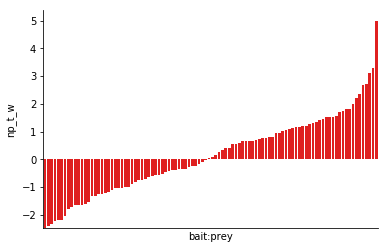

In [65]:
%matplotlib inline
x=merged['bait:prey']
y=merged['np_t_w']
clrs = ['red' if pair not in top10 else 'red' for pair in x ]


sns.barplot(x='bait:prey', y='np_t_w', data=best_samp, palette=clrs)
sns.despine()
plt.xticks([])

# Compute 1M Sample Breast CLOvE

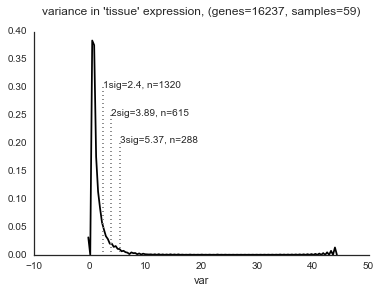

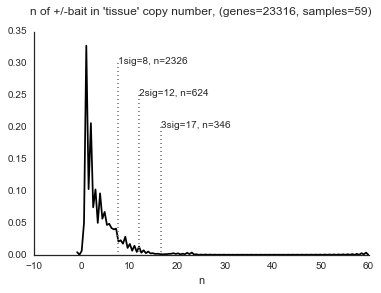

In [2]:
%matplotlib inline
expdf, cnvdf = load_data('data/breast_mrna.tab.gz', 'data/breast_CCLE_DEL_calls.csv.gz')

In [3]:
expdf, cnvdf = mainFitler(expdf, cnvdf, var=2, n=8)

exp: (16237, 59) --> filter --> (1688, 59)
cnv: (23316, 59) --> filter --> (2278, 59)
3845264 CLOvE pairs are possible with these parameters
estimated calculation time: 44.86141333333333min (~7sec/10k pairs)


In [5]:
matchdf = pd.read_csv('data/brca_1M_clove_pivot.tab.gz', compression='gzip', sep='\t', index_col=0)
matchdf
# %matplotlib inline
# bexp, bcnv = clv.load_data('data/lung_mrna_df.pickle', 'data/lung_cnv_df.p', details=True)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,hsa-mir-664,hsa-mir-720,hsa-mir-886,hsa-mir-887,hsa-mir-924,hsa-mir-941-1,hsa-mir-941-2,hsa-mir-941-3,hsa-mir-95,hsa-mir-96
exp,,,,,,,,,,,,,,,,,,,,,
A1BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2BP1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2LD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2ML1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.2253,NaN,NaN,NaN,NaN
A4GALT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A4GNT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## graph distribution of copy numer in LUNG CCLE 

In [2]:
calls = pd.read_pickle('data_large/CCLE_DEL_calls.pickle')
cellinfo = pd.read_pickle('data_large/ccle_cell_info_df.pickle')
lungcnv = pd.read_pickle('data/lung_cnv_df.pickle')
lungexp = pd.read_pickle('data/lung_mrna_df.pickle')

In [3]:
lungexp1, lungcnv1  = clv.ccleTissueSelect(expdf_fn='data/lung_mrna_df.pickle',
                                         cnvdf_fn='data_large/CCLE_DEL_calls.pickle',
                                         celldf_fn='data_large/ccle_cell_info_df.pickle',
                                         tissue='lung', out_dir='data/')

mean:  0.0003419580682746488
std:  0.0004864900226009831


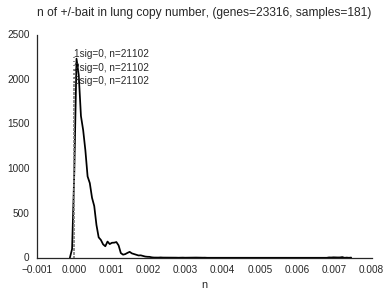

In [4]:
%matplotlib inline
clv.graph_n_ratio(lungcnv1, 'lung', y0=2250, yd=150)

mean:  7.964873906330417
std:  11.298861660411463


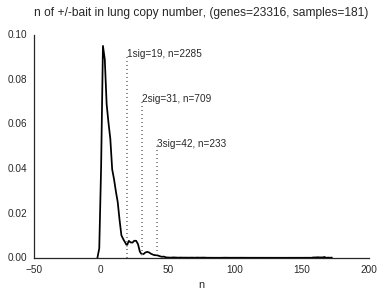

In [9]:
clv.graph_n_dist(lungcnv1, tissue='lung', y0=0.09, yd=0.02)

mean:  7.96913214053
std:  2.00143772104


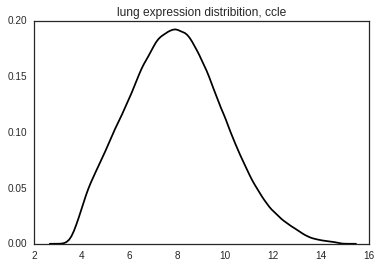

In [25]:
exp_arr = lungexp.values.flatten()
exp_arr =exp_arr[~np.isnan(exp_arr)]
print('mean: ', np.mean(exp_arr))
print('std: ', np.std(exp_arr))
sns.distplot(exp_arr, hist=False, color='black')
plt.title('lung expression distribition, ccle')


mean:  0.00664955547931
std:  0.455208235057


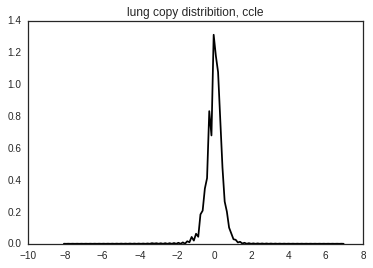

In [24]:
exp_cnv = lungcnv.values.flatten()
exp_cnv =exp_cnv[~np.isnan(exp_cnv)]
print('mean: ', np.mean(exp_cnv))
print('std: ', np.std(exp_cnv))
sns.distplot(exp_cnv, hist=False, color='black')
plt.title('lung copy distribition, ccle')

## compare GISTIC log2 values with REVEALER calls


In [2]:
gistic = pd.read_pickle('data/lung_cnv_df.pickle')
lungexp, reveal = clv.ccleTissueSelect(expdf_fn='data/lung_mrna_df.pickle',
                                         cnvdf_fn='data_large/CCLE_DEL_calls.pickle',
                                         celldf_fn='data_large/ccle_cell_info_df.pickle',
                                         tissue='lung', out_dir='data/')

In [3]:
print(gistic.shape)
gistic.head(1)

(23316, 180)


,A549_LUNG,ABC1_LUNG,BEN_LUNG,CAL12T_LUNG,CALU1_LUNG,CALU3_LUNG,CALU6_LUNG,CHAGOK1_LUNG,COLO668_LUNG,CORL105_LUNG,...,SKLU1_LUNG,SKMES1_LUNG,SQ1_LUNG,SW1271_LUNG,SW1573_LUNG,SW900_LUNG,T3M10_LUNG,TIG3TD_LUNG,VMRCLCD_LUNG,VMRCLCP_LUNG
SYMBOL,,,,,,,,,,,,,,,,,,,,,
A1BG,0.4405,0.7541,0.1362,-0.3696,-0.3462,0.3349,0.2393,0.3836,-0.5689,0.3113,...,-0.0661,0.2115,-0.4725,-0.24,-0.1081,0.1534,0.1002,0.0199,-0.192,0.6702


In [4]:
print(reveal.shape)
reveal.head(1)

(23316, 181)


,HCC366_LUNG,NCIH661_LUNG,NCIH727_LUNG,RERFLCAI_LUNG,NCIH2029_LUNG,DMS273_LUNG,LXF289_LUNG,HS618T_LUNG,NCIH1930_LUNG,IALM_LUNG,...,NCIH2085_LUNG,NCIH2023_LUNG,NCIH2342_LUNG,NCIH226_LUNG,NCIH510_LUNG,NCIH2066_LUNG,NCIH1734_LUNG,LUDLU1_LUNG,NCIH2106_LUNG,SALE_LUNG
Name,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
l = pd.DataFrame(reveal.stack()).reset_index()
l.columns = ['gene','cell','reveler_del']
r = pd.DataFrame(gistic.stack()).reset_index()
r.columns = ['gene','cell','gistic_val']
rev_gis_merge = pd.merge(left=l, right=r, left_on=['gene','cell'], right_on=['gene','cell'])

In [28]:
pal = {0: "gray", 1: "red"}

Ttest_indResult(statistic=1351.1892119949173, pvalue=0.0)


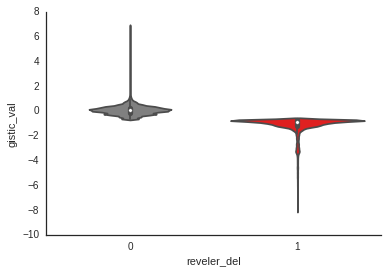

In [31]:
pal = {0: "gray", 1: "red"}

tt = stats.ttest_ind(rev_gis_merge[rev_gis_merge['reveler_del']==0]['gistic_val'],
                rev_gis_merge[rev_gis_merge['reveler_del']==1]['gistic_val'])
print(tt)
%matplotlib inline
sns.set_style('white')
sns.violinplot(data=rev_gis_merge, x='reveler_del', y='gistic_val', palette=pal)
sns.despine()

In [6]:
# from cloveFunctions import *

def matchPairContextStat(expdf, cnvdf, new_cohort, matchdf, match_cohort, nan_style='omit', permute=False):
    """
    computes clove pairs from one sample that match with those computed in some other cohorts
    
    :param expdf: pandas dataframe, expression by sample 
                    (hopefully filtered with mainFilter, tissue specific, with matching samples in cnv)
    :param cnvdf: pandas dataframe, binarized mask 5(1=delete, 0=nodelete) deletion by sample 
                    (hopefully filtered with mainFilter, tissue specific, with matching samples in exp)
    :param new_cohort: str, identifier for the current cohort computation (eg, tissue origin of exp and cnv)
    :param matchdf: pandas dataframe, results of clove computation performed in other cohort
                    exp and cnv pairs will be used to populate the new clove results so pairs match between cohort
    :param match_cohort: str, identifier for the matching (precomputed) cohort used (eg, tissue origin of matchdf)
    :param nan_style: str, how the stats.ttest_ind treats NANs, {‘propagate’, ‘raise’, ‘omit’}
    :param permute: bool, True will calculate pairs with randomly permuted expression matrix as null model
    
    returns df[['exp', 'cnv', 'cntxt_pos_mu', 'cntxt_neg_mu', 
                'cntxt_pos_var', 'cntxt_neg_var', 
                'cntxt_pos_n', 'cntxt_neg_n']]
    """
    
    cells = list(set(cnvdf.columns).intersection(expdf.columns)) # confirm same samples in both cnv and exp
    expdf = expdf[cells]
    cmask = cnvdf[cells] == 1
    
    df = matchdf[['exp', 'cnv', 'np_t_w', 'np_t_w_null','np_p_w']]
    df.columns = ['exp', 'cnv', 't_'+match_cohort, 't_null_'+match_cohort, 'p_'+match_cohort,]
    
    if permute:
        cmask_n = scrambleDF(cmask)
    
#     only keep elements of matchdf['exp'] that are also in expdf.index
    df = df[(df['exp'].isin(expdf.index)) & (df['cnv'].isin(cnvdf.index))]
    print('attempting {} comparisons referenced from {}'.format(df.shape[0], match_cohort))
    
    np_t_w, np_p_w, np_t_w_null = [], [], []
  
    # progress initialize
    count=0
    percent_complete=0
    comparisons = df.shape[0]
    
    for row in df.itertuples():
        # progress report
        count+=1
        if count%(comparisons/10)==0:
            print('hiii')
            print(np.array(expdf.loc[row.exp][cmask.loc[row.cnv]]))
            percent_complete+=10
            print('pair computation {}% complete ({}/{})'.format(percent_complete, count, comparisons))
        
        # mask cnv contexts onto expression data
        pos = np.array(expdf.loc[row.exp][cmask.loc[row.cnv]])
        neg = np.array(expdf.loc[row.exp][~cmask.loc[row.cnv]])
        
        # calculate t_stat, welch
        t, p = stats.ttest_ind(pos, neg, nan_policy=nan_style, equal_var=True)
        if type(np_t_w) == np.ma.core.MaskedConstant:
            print('its masked')
            print([pos, neg])
            np_t_w.append(np.nan)
            np_p_w.append(np.nan)
        else:    
            np_t_w.append(t)
            np_p_w.append(p)
        
        if permute:
            pos = np.array(expdf.loc[row.exp][cmask_n.loc[row.cnv]])
            neg = np.array(expdf.loc[row.exp][~cmask_n.loc[row.cnv]])
            t, p = stats.ttest_ind(pos, neg, nan_policy=nan_style, equal_var=True)
            np_t_w_null.append(t)
   
    df['t_'+new_cohort] = np_t_w
    df['p_'+new_cohort] = np_p_w
    
    if permute:
        df['t_null_'+new_cohort] = np_t_w_null
        
    return df, np_t_w

## Compute Some Sample Lung CLOvE matching pre-computed TCGA values

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import cloveFunctions as clv
import matplotlib
# matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
# matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import warnings
warnings.filterwarnings('ignore')

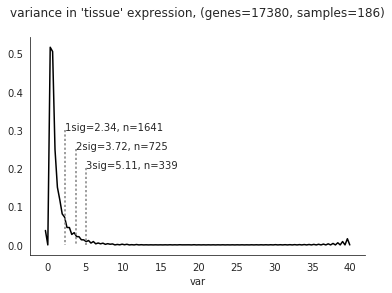

mean:  7.964873906330417
std:  11.298861660411463


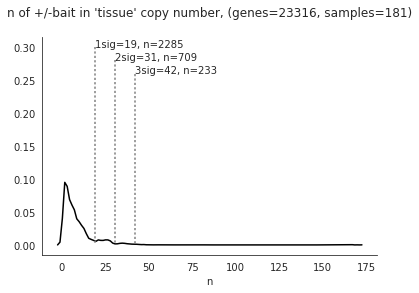

In [2]:
# bring in exp and cnv data from
# G:\My Drive\Python Scripts\clove\tissueDF_raw

matchdf = pd.read_csv('data/tcga_lung_cloves.tab.gz', compression='gzip', sep='\t', index_col=0)
%matplotlib inline
lungexp, lungcnv = clv.load_data('data/lung_mrna_df.pickle', 'data/lung_cnv_df.p', details=True)

In [3]:
v_min, n_min = 2, 2
lungexp, lungcnv = clv.mainFitler(lungexp, lungcnv, var=v_min, n=n_min)

exp: (17380, 186) --> filter --> (2030, 180)
cnv: (23316, 181) --> filter --> (18312, 180)
37173360 CLOvE pairs are possible with these parameters
estimated calculation time: 433.68919999999997min (~7sec/10k pairs)


In [4]:
lungresults = clv.matchPairContextStat(lungexp, lungcnv, 'ccle_lung', matchdf, 'tcga_lung', nan_style='omit', min_var=v_min, min_n=n_min, permute=False)

attempting 50612 comparisons referenced from tcga_lung (var>2, n>2
pair computation 10% complete (5061/50612)
pair computation 20% complete (10122/50612)
pair computation 30% complete (15183/50612)
pair computation 40% complete (20244/50612)
pair computation 50% complete (25305/50612)
pair computation 60% complete (30366/50612)
pair computation 70% complete (35427/50612)
pair computation 80% complete (40488/50612)
pair computation 90% complete (45549/50612)
pair computation 100% complete (50610/50612)
50612


In [7]:
lungresults.to_csv('data/tcga_v_ccle_lung.tab.gz', sep='\t', compression='gzip')

To Do
Debug matchPairContextStat func in tgca_vs_ccle.ipynb
Add save parameter
Run above func to compute CCLE lung matching pairs in data/tcga_lung_cloves.tab.gz
Write function to Graph Scatter (with 3𝞭 cutoff) 
Graph above func for lung CCLE vs TCGA
Run millions of comparisons in TCGA BRCA
Re-run millions of comparisons in CCLE breast?
If not, use existing CCLE breast cloves to dictate which pairs tested
Run millions of comparisons in TCGA BRCA
Housekeeping
Func load_data created to handle raw input files directly
Relies on Func graph_var_dist and graph_n_dist to display summary stats n and var for use in filtering
TODO add in tissue/cohort subset option
Func matchPairContextStat computes pairs in new data according to pairs defined in old data.  Used to match pair for pair across each cohort
TODO test/debug in ccle_sandbox


WHY ARE THERE SO MANY -- IN MY DATA?

In [6]:
lungresults.dropna()

,exp,cnv,t_tcga_lung,p_tcga_lung,t_ccle_lung,p_ccle_lung
856,BCHE,APOD,2.232715,2.579047e-02,-1.011340,0.315547
863,BCHE,TAS2R20,3.081984,2.113071e-03,0.505528,0.614872
865,BCHE,TMEM120A,1.182565,2.372653e-01,0.235038,0.814907
880,BCHE,CT45A3,1.159753,2.464288e-01,0.255718,0.798964
905,BCHE,THAP7,4.098205,4.504141e-05,1.431856,0.156904
906,RASSF6,CT47A7,-1.100798,2.712521e-01,0.386493,0.699852
912,RASSF6,CCL5,-3.415620,6.621911e-04,-0.354742,0.723438
917,RASSF6,SOX5,0.185942,8.525280e-01,0.593309,0.554150
927,RASSF6,RFPL1,-0.272796,7.850665e-01,-0.852622,0.395657
934,RASSF6,RNF182,-2.127327,3.363938e-02,0.521989,0.602691


In [7]:
lungresults.to_csv('data/tcga_v_ccle_lung.tab.gz', sep='\t', compression='gzip')
# lungresults = pd.read_csv('data/tcga_v_ccle_lung.tab.gz', sep='\t', compression='gzip', index_col=0)

In [8]:
lungresults[lungresults['t_ccle_lung'] == np.ma.core.MaskedConstant]

,exp,cnv,t_tcga_lung,t_null_tcga_lung,p_tcga_lung,t_ccle_lung,p_ccle_lung


GRAPH LUNG CCLE vs TCGA 3sig

In [76]:
# lungresults.to_csv('data/tcga_v_ccle_lung.tab.gz', sep='\t', compression='gzip')
lungresults = pd.read_csv('data/tcga_v_ccle_lung.tab.gz', sep='\t', compression='gzip', index_col=0)

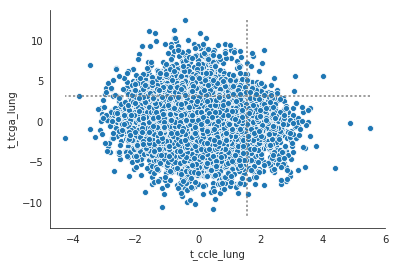

In [20]:
%matplotlib inline

def graph_clove_clove(df=lungresults, x='t_ccle_lung', y='t_tcga_lung'):
    s1_ccle = np.std(df[x])*1.5
    s1_tcga = np.std(df[y])*1.5

    sns.set_style("white")
    sns.scatterplot(x=df[x], y=df[y])
    plt.plot([s1_ccle,s1_ccle], [df[y].max(), df[y].min()], linestyle='dotted', color='gray')
    plt.plot([df[x].max(), df[x].min()],[s1_tcga,s1_tcga],  linestyle='dotted', color='gray')
    sns.despine()
    
    df = df[(df[y]>s1_tcga) & (lungresults[x]>s1_ccle)]
    df['prod'] = df[x] * df[y]
    
    return df.sort_values(by='prod', ascending=False)

def table_clove_clove(df=lungresults, x='t_ccle_lung', y='t_tcga_lung'):
    s1_ccle = np.std(df[x])*1.5
    s1_tcga = np.std(df[y])*1.5

    return df[(df[y]>s1_tcga) & (lungresults[x]>s1_ccle)]

lung = graph_clove_clove()

In [21]:
lung

,exp,cnv,t_tcga_lung,p_tcga_lung,t_ccle_lung,p_ccle_lung,prod
871390,MATN2,P2RX6,5.624647,2.417490e-08,4.014808,0.000090,22.581877
747820,FERMT1,GSTTP1,8.747412,9.233116e-18,2.100874,0.037163,18.377214
871402,MATN2,ZDHHC8,5.624647,2.417490e-08,3.118817,0.002137,17.542244
391312,ITGB5,CLDN5,7.201381,1.177691e-12,2.034270,0.043526,14.649554
168823,CSRP2,ZDHHC19,8.373404,1.893301e-16,1.723356,0.086611,14.430355
147616,SFN,RTDR1,8.019258,2.984272e-15,1.755211,0.080944,14.075490
947226,ITGA6,CRNKL1,5.327829,1.230366e-07,2.421712,0.016499,12.902468
1634,NRCAM,WNT5B,6.242904,6.359863e-10,1.942676,0.054733,12.127941
391282,ITGB5,GAS2L1,6.815004,1.634475e-11,1.707531,0.089604,11.636830
434078,INHBE,TAS2R30,3.768095,1.742044e-04,3.058910,0.002935,11.526264


In [46]:
kid_cloves_ccle = pd.read_csv('data/kidney_ttest_1M.tab.gz', compression='gzip', sep='\t')
kid_cloves_tcga = pd.read_csv('data/tcga_kidney_cloves.tab.gz', compression='gzip', sep='\t')

In [49]:
kid_cloves_ccle.head(1)

,Unnamed: 0,exp,cnv,np_t_w,np_p_w,np_t_w_null
0,0,MYBL1,LOC100130417,1.15019918524,0.258857718139,0.225918995171


In [50]:
kid_cloves_tcga.head(1)

,Unnamed: 0,exp,cnv,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,np_t_w_null,t_shrnk_glob,gene_var_exp
0,0,TMEM84|283673,TPPP,231,754,16.738888,16.894549,1284.58178,1822.180101,-0.003776,-0.050209,0.959966,-0.452129,-0.000706,1697.83178
